# Costmap Tutorial

This notebook teaches you how to use costmaps for obstacle representation and inflation in the Simple Autonomous Car SDK.

## What You'll Learn

1. Understanding costmaps and their purpose
2. Creating and updating costmaps from perception data
3. Using inflation for safety margins
4. Integrating costmaps with planners and controllers
5. Visualizing costmaps

## What is a Costmap?

A costmap is a grid-based representation of the environment where each cell has a cost value:
- **0.0** = Free space (safe to traverse)
- **1.0** = Occupied (obstacle)
- **0.0-1.0** = Inflated (cost increases near obstacles)

Costmaps are essential for:
- **Obstacle avoidance**: Planners can avoid high-cost areas
- **Safety margins**: Inflation creates safety buffers around obstacles
- **Velocity control**: Controllers can slow down in high-cost areas

In [8]:
import sys
sys.path.insert(0, '../../src')

import numpy as np
import matplotlib.pyplot as plt
from simple_autonomous_car import (
    Track,
    Car,
    CarState,
    GroundTruthMap,
    PerceivedMap,
    LiDARSensor,
    GridCostmap,
    plot_track,
    plot_perception,
    plot_costmap,
    plot_costmap_with_path,
)

## Step 1: Setup - Create Track, Car, and Sensors

In [9]:
# Create track
track = Track.create_simple_track(length=80.0, width=40.0, track_width=5.0)

# Create car at starting position
start_point, start_heading = track.get_point_at_distance(0.0)
car = Car(
    initial_state=CarState(
        x=start_point[0],
        y=start_point[1],
        heading=start_heading,
        velocity=8.0
    )
)

# Create maps and sensor
ground_truth_map = GroundTruthMap(track)
perceived_map = PerceivedMap(
    ground_truth_map,
    position_noise_std=0.15,
    orientation_noise_std=0.08,
    measurement_noise_std=0.2,
)

lidar = LiDARSensor(
    ground_truth_map=ground_truth_map,
    perceived_map=perceived_map,
    max_range=40.0,
    angular_resolution=0.1,
    point_noise_std=0.1,
    name="lidar",
)
car.add_sensor(lidar)

print(f"✓ Setup complete")
print(f"  Track: {len(track.centerline)} points")
print(f"  Car at: ({car.state.x:.2f}, {car.state.y:.2f})")
print(f"  Sensors: {len(car.sensors)}")

✓ Setup complete
  Track: 400 points
  Car at: (-28.00, -20.00)
  Sensors: 1


## Step 2: Create and Update Costmap

In [10]:
# Create costmap
costmap = GridCostmap(
    width=60.0,           # 60m wide
    height=60.0,          # 60m tall
    resolution=0.5,       # 0.5m per cell (120x120 cells)
    inflation_radius=2.0, # Inflate obstacles by 2m
    frame="ego",         # Ego frame (moves with car)
)

print(f"✓ Costmap created")
print(f"  Size: {costmap.width_pixels}x{costmap.height_pixels} cells")
print(f"  Resolution: {costmap.resolution}m/cell")
print(f"  Inflation radius: {costmap.inflation_radius}m")
print(f"  Frame: {costmap.frame}")

✓ Costmap created
  Size: 120x120 cells
  Resolution: 0.5m/cell
  Inflation radius: 2.0m
  Frame: ego


In [11]:
# Get perception data
perception_data = car.sense_all(environment_data={"ground_truth_map": ground_truth_map})

# Update costmap from perception
costmap.update(perception_data, car.state)

print(f"✓ Costmap updated from perception data")
print(f"  Max cost: {costmap.get_full_costmap().max():.2f}")
print(f"  Occupied cells: {(costmap.get_full_costmap() >= 0.5).sum()}")
print(f"  Inflated cells: {(costmap.get_full_costmap() > 0.0).sum() - (costmap.get_full_costmap() >= 0.5).sum()}")

✓ Costmap updated from perception data
  Max cost: 1.00
  Occupied cells: 1249
  Inflated cells: 877


## Step 3: Visualize Costmap

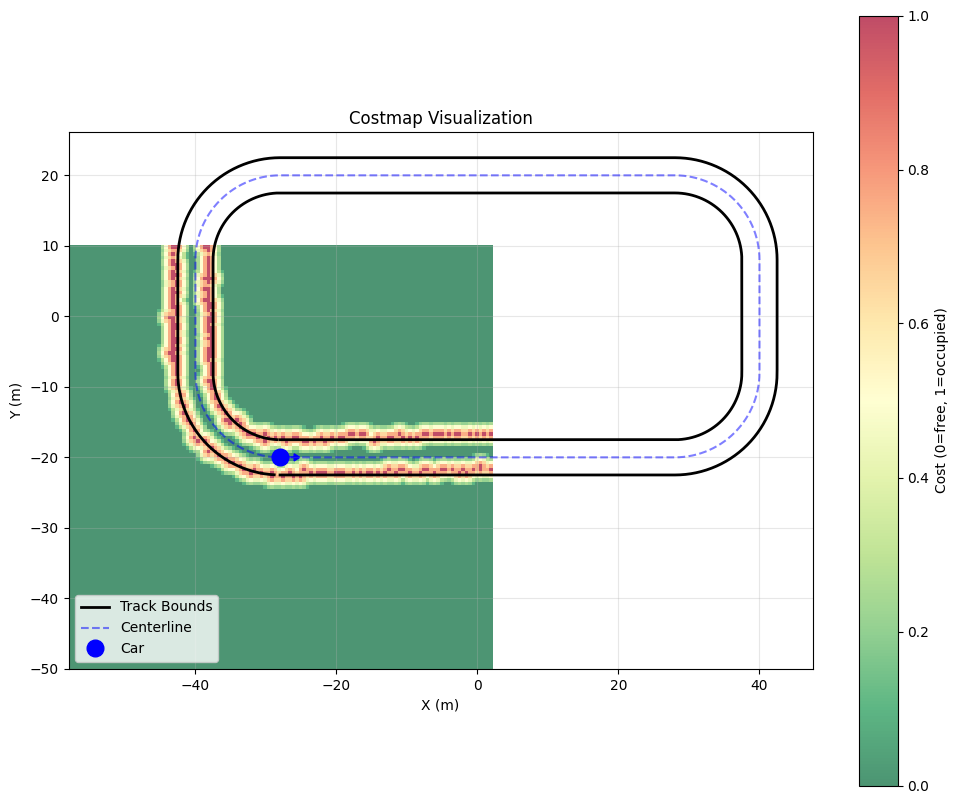


Color coding:
  - Red = High cost (obstacles + inflation)
  - Yellow = Medium cost (inflated areas)
  - Green = Low cost (free space)


In [12]:
# Visualize costmap
fig, ax = plt.subplots(figsize=(12, 10))
plot_track(track, ax=ax)
plot_costmap(costmap, car.state, ax=ax, show_car=True)
plt.title("Costmap Visualization")
plt.legend()
plt.show()

print("\nColor coding:")
print("  - Red = High cost (obstacles + inflation)")
print("  - Yellow = Medium cost (inflated areas)")
print("  - Green = Low cost (free space)")

## Step 4: Understanding Inflation

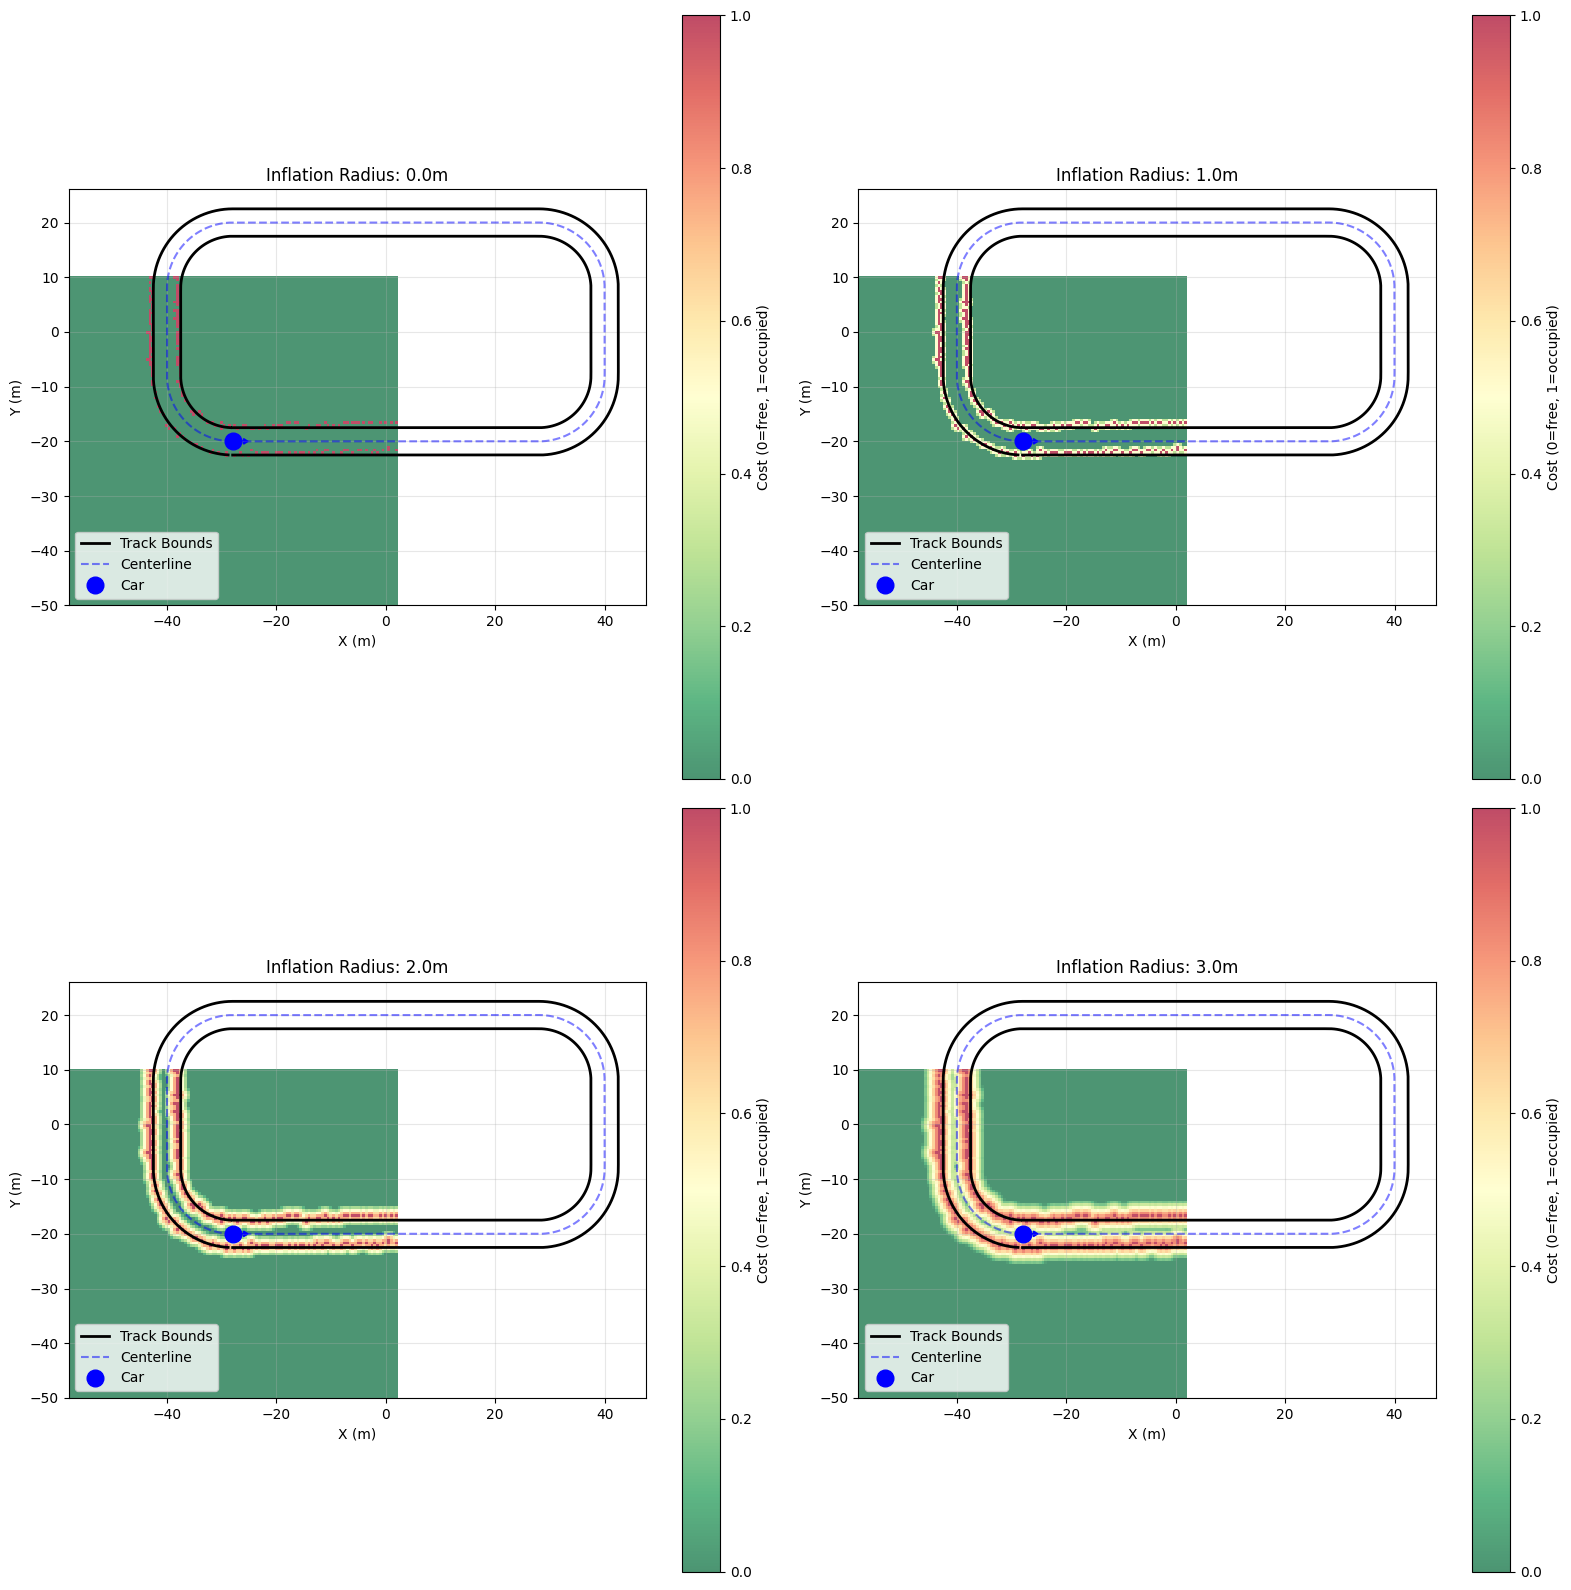


Notice how inflation creates safety margins around obstacles:
  - Larger radius = larger safety margin
  - Cost decreases linearly from obstacle to inflation radius


In [13]:
# Compare different inflation radii
inflation_radii = [0.0, 1.0, 2.0, 3.0]

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, radius in enumerate(inflation_radii):
    # Create costmap with different inflation
    test_costmap = GridCostmap(
        width=60.0,
        height=60.0,
        resolution=0.5,
        inflation_radius=radius,
        frame="ego",
    )
    test_costmap.update(perception_data, car.state)

    # Plot
    plot_track(track, ax=axes[idx])
    plot_costmap(test_costmap, car.state, ax=axes[idx], show_car=True)
    axes[idx].set_title(f"Inflation Radius: {radius}m")

plt.tight_layout()
plt.show()

print("\nNotice how inflation creates safety margins around obstacles:")
print("  - Larger radius = larger safety margin")
print("  - Cost decreases linearly from obstacle to inflation radius")

## Step 5: Querying Costs

In [14]:
# Query cost at specific positions
test_positions = [
    np.array([10.0, 0.0]),   # Ahead of car
    np.array([5.0, 5.0]),   # To the left
    np.array([5.0, -5.0]),  # To the right
    np.array([20.0, 0.0]),  # Far ahead
]

print("Cost at different positions:")
for pos in test_positions:
    # Transform to global frame (since costmap is in ego frame)
    pos_global = car.state.transform_to_world_frame(pos)
    cost = costmap.get_cost(pos_global, frame="global", car_state=car.state)
    print(f"  Position {pos}: cost = {cost:.3f}")

Cost at different positions:
  Position [10.  0.]: cost = 0.000
  Position [5. 5.]: cost = 0.000
  Position [ 5. -5.]: cost = 0.000
  Position [20.  0.]: cost = 0.000


In [15]:
# Get cost in a region
center = car.state.position()
region_size = 10.0  # 10m x 10m region

region_costs = costmap.get_cost_region(
    center=center,
    size=region_size,
    frame="global",
    car_state=car.state,
)

print(f"\nCost region around car ({region_size}m x {region_size}m):")
print(f"  Shape: {region_costs.shape}")
print(f"  Min cost: {region_costs.min():.3f}")
print(f"  Max cost: {region_costs.max():.3f}")
print(f"  Mean cost: {region_costs.mean():.3f}")


Cost region around car (10.0m x 10.0m):
  Shape: (20, 20)
  Min cost: 0.000
  Max cost: 1.000
  Mean cost: 0.429


## Step 6: Using Costmap with Planner

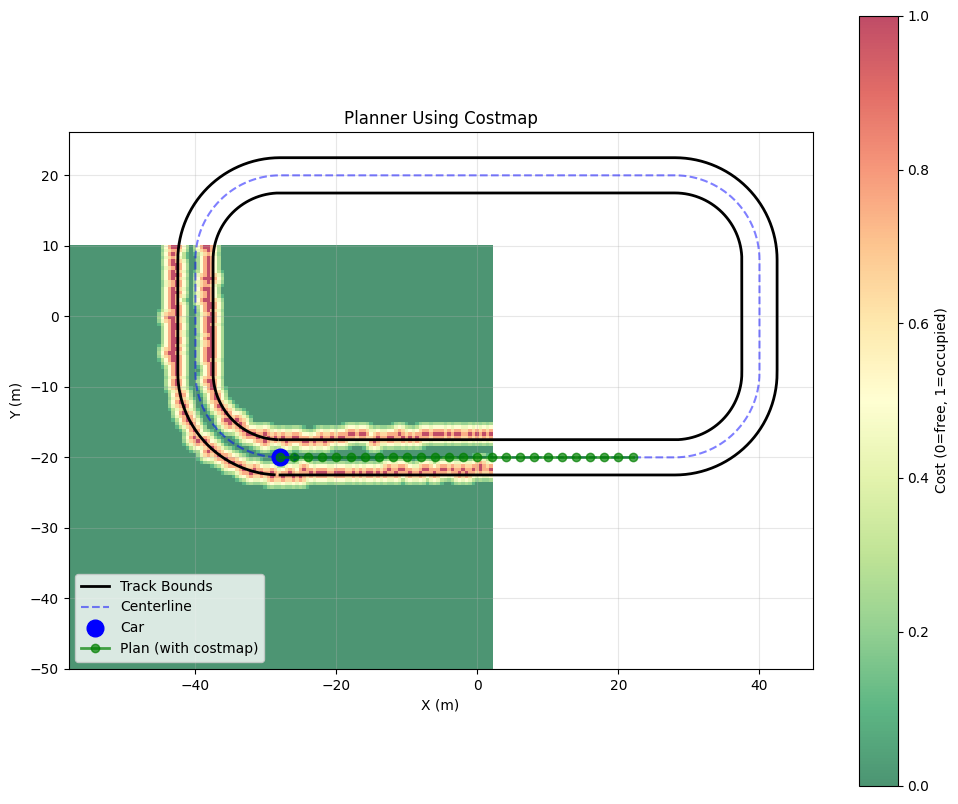


Plan without costmap: 26 waypoints
Plan with costmap: 26 waypoints


In [16]:
from simple_autonomous_car import TrackPlanner, plot_plan

# Create planner
planner = TrackPlanner(track, lookahead_distance=50.0, waypoint_spacing=2.0)

# Generate plan without costmap
plan_no_costmap = planner.plan(car.state)

# Generate plan with costmap (planner can avoid high-cost areas)
plan_with_costmap = planner.plan(car.state, perception_data=perception_data, costmap=costmap)

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
plot_track(track, ax=ax)
plot_costmap(costmap, car.state, ax=ax, show_car=True)
plot_plan(plan_with_costmap, ax=ax, color="green", label="Plan (with costmap)")
plt.title("Planner Using Costmap")
plt.legend()
plt.show()

print(f"\nPlan without costmap: {len(plan_no_costmap)} waypoints")
print(f"Plan with costmap: {len(plan_with_costmap)} waypoints")

## Step 7: Using Costmap with Controller

In [17]:
from simple_autonomous_car import PurePursuitController

# Create controller
controller = PurePursuitController(lookahead_distance=10.0, target_velocity=10.0)

# Generate plan
plan = planner.plan(car.state, perception_data=perception_data, costmap=costmap)

# Compute control without costmap
control_no_costmap = controller.compute_control(
    car.state,
    perception_data=perception_data,
    plan=plan,
)

# Compute control with costmap (controller adjusts velocity based on cost ahead)
control_with_costmap = controller.compute_control(
    car.state,
    perception_data=perception_data,
    costmap=costmap,
    plan=plan,
)

print("Control commands:")
print(f"  Without costmap:")
print(f"    Acceleration: {control_no_costmap['acceleration']:.2f} m/s²")
print(f"    Steering rate: {control_no_costmap['steering_rate']:.2f} rad/s")
print(f"\n  With costmap:")
print(f"    Acceleration: {control_with_costmap['acceleration']:.2f} m/s²")
print(f"    Steering rate: {control_with_costmap['steering_rate']:.2f} rad/s")
print("\n  Note: Controller reduces velocity in high-cost areas!")

Control commands:
  Without costmap:
    Acceleration: 1.00 m/s²
    Steering rate: 0.00 rad/s

  With costmap:
    Acceleration: 1.00 m/s²
    Steering rate: 0.00 rad/s

  Note: Controller reduces velocity in high-cost areas!


## Step 8: Complete Example - Costmap in Simulation Loop

In [18]:
# Complete simulation loop with costmap
dt = 0.1
num_steps = 50

# Store trajectory
trajectory = []

for step in range(num_steps):
    # 1. Get perception
    perception_data = car.sense_all(environment_data={"ground_truth_map": ground_truth_map})

    # 2. Update costmap
    costmap.update(perception_data, car.state)

    # 3. Generate plan (with costmap)
    plan = planner.plan(car.state, perception_data=perception_data, costmap=costmap)

    # 4. Compute control (with costmap)
    control = controller.compute_control(
        car.state,
        perception_data=perception_data,
        costmap=costmap,
        plan=plan,
    )

    # 5. Update car
    car.update(dt, acceleration=control["acceleration"], steering_rate=control["steering_rate"])

    # Store trajectory
    trajectory.append(car.state.position().copy())

print(f"✓ Simulation complete! Car traveled {len(trajectory)} steps")
print(f"  Final position: ({car.state.x:.2f}, {car.state.y:.2f})")
print(f"  Final velocity: {car.state.velocity:.2f} m/s")

✓ Simulation complete! Car traveled 50 steps
  Final position: (18.42, -19.04)
  Final velocity: 9.68 m/s


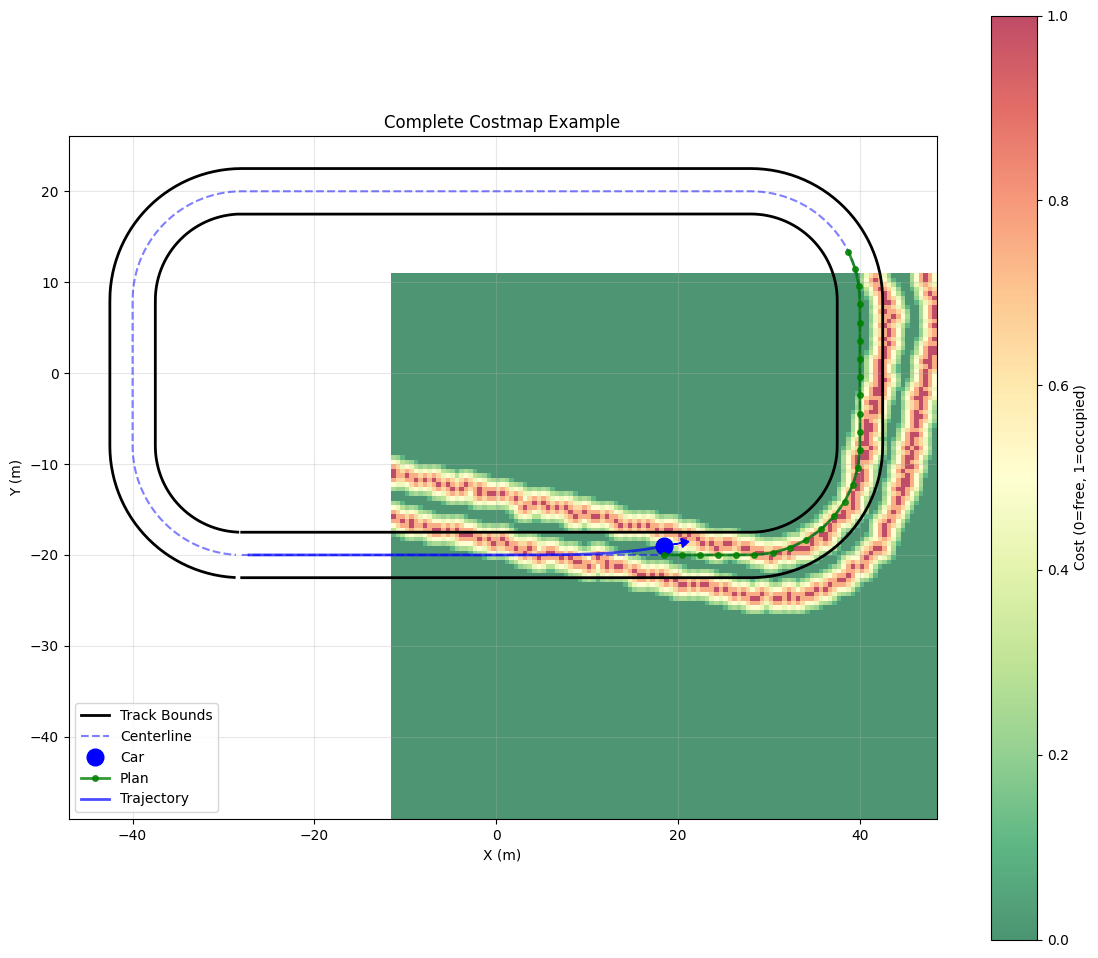

In [19]:
# Visualize final state
fig, ax = plt.subplots(figsize=(14, 12))

# Update costmap one more time
perception_data = car.sense_all(environment_data={"ground_truth_map": ground_truth_map})
costmap.update(perception_data, car.state)
plan = planner.plan(car.state, perception_data=perception_data, costmap=costmap)

# Plot everything
plot_track(track, ax=ax)
plot_costmap_with_path(costmap, plan, car.state, ax=ax)

# Plot trajectory
if len(trajectory) > 1:
    traj_array = np.array(trajectory)
    ax.plot(traj_array[:, 0], traj_array[:, 1], 'b-', linewidth=2, alpha=0.7, label='Trajectory')

plt.title("Complete Costmap Example")
plt.legend()
plt.show()

## Summary

You've learned:

1. ✅ **Creating costmaps**: Grid-based obstacle representation
2. ✅ **Updating from perception**: Convert sensor data to costmap
3. ✅ **Inflation**: Create safety margins around obstacles
4. ✅ **Querying costs**: Get cost at positions or in regions
5. ✅ **Integration with planners**: Planners can use costmaps for obstacle avoidance
6. ✅ **Integration with controllers**: Controllers adjust behavior based on cost
7. ✅ **Visualization**: Easy plotting of costmaps

### Key Concepts

- **Cost values**: 0.0 = free, 1.0 = occupied, 0.0-1.0 = inflated
- **Inflation radius**: Safety margin around obstacles
- **Frame support**: Global or ego frame
- **Integration**: Works with planners, controllers, and sensors

### Next Steps

- Build custom planners that use costmaps for obstacle avoidance
- Build custom controllers that react to costmap
- Experiment with different inflation radii
- Combine costmaps with other planning techniques